#Fully Convolutional Neural Networks for Image Segmentation

This notebook illustrates how to build a Fully Convolutional Neural Network for semantic image segmentation.

# Imports

In [ ]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
from keras.callbacks import EarlyStopping

# Download the Dataset

The dataset is hosted in a Google bucket so you will need to download it first and unzip to a local directory.

In [ ]:
# download the dataset (zipped file)
!wget --no-check-certificate \
    https://storage.googleapis.com/semantic_segmentation_for_self_driving_cars_dataset/Semantic_Segmentation_dl.zip \
    -O /tmp/Semantic_Segmentation_dl.zip

# extract the downloaded dataset to a local directory: /tmp/Semantic_Segmentation
local_zip = '/tmp/Semantic_Segmentation_dl.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/Semantic_Segmentation')
zip_ref.close()

--2021-07-05 12:45:30--  https://storage.googleapis.com/semantic_segmentation_for_self_driving_cars_dataset/Semantic_Segmentation_dl.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 547791422 (522M) [application/x-zip-compressed]
Saving to: ‘/tmp/Semantic_Segmentation_dl.zip’

/tmp/Semantic_Segme 100%[===================>] 522.41M   112MB/s    in 4.8s    

2021-07-05 12:45:35 (110 MB/s) - ‘/tmp/Semantic_Segmentation_dl.zip’ saved [547791422/547791422]



In [ ]:
'''
create a list containing the class names
'''
class_names = ['Unlabeled', 'Building','Fence', 'Other', 'Pedestrian', 'Pole', 'RoadLine', 'Road', 'SideWalk', 'Vegetation', 'Vehicles', 'Wall','TrafficSign','Sky','Ground','Bridge','RailTrack','GuardRail','TrafficLight','Static','Dynamic','Water','Terrain']

# Load and Prepare the Dataset

In [ ]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=224, width=224):
  '''
  Preprocesses the dataset by:
    * resizing the input image and label maps
    * normalizing the input image pixels
    * reshaping the label maps from (height, width, 1) to (height, width, 23)

  Args:
    t_filename (string) -- path to the raw input image
    a_filename (string) -- path to the raw annotation (label map) file
    height (int) -- height in pixels to resize to
    width (int) -- width in pixels to resize to

  Returns:
    image (tensor) -- preprocessed image
    annotation (tensor) -- preprocessed annotation
  '''

  # Convert image and mask files to tensors 
  img_raw = tf.io.read_file(t_filename)
  anno_raw = tf.io.read_file(a_filename)
  image = tf.image.decode_png(img_raw) #Decode a PNG-encoded image to a uint8 or uint16 tensor.
  annotation = tf.image.decode_png(anno_raw)
  # print(annotation)

  # Resize image and segmentation mask
  image = tf.image.resize(image, (height, width,))
  annotation = tf.image.resize(annotation, (height, width,))
  image = tf.reshape(image, (height, width, 3,))
  # print(annotation)
  annotation = tf.cast(annotation, dtype=tf.int32)
  annotation = tf.reshape(annotation, (height, width, 1,))
  print(annotation[:,:,0])
  stack_list = []

  # Reshape segmentation masks
  for c in range(len(class_names)):
    mask = tf.equal(annotation[:,:,0], tf.constant(c))
    stack_list.append(tf.cast(mask, dtype=tf.int32))
    print(tf.constant(c))
  
  annotation = tf.stack(stack_list, axis=2)
  # print(annotation)
  # Normalize pixels in the input image
  image = image/255
  image -= 1
  # print(image)

  return image, annotation

The following functions are used to create the tensorflow datasets from the images in these folders. Notice that before creating the batches in the `get_training_dataset()` and `get_validation_set()`, the images are first preprocessed using the `map_filename_to_image_and_mask()` function.

### Utilities for preparing the datasets

#### get_dataset_slice_paths

In [ ]:
BATCH_SIZE = 64

def get_dataset_slice_paths(image_dir, label_map_dir):
  '''
  generates the lists of image and label map paths
  
  Args:
    image_dir (string) -- path to the input images directory
    label_map_dir (string) -- path to the label map directory

  Returns:
    image_paths (list of strings) -- paths to each image file
    label_map_paths (list of strings) -- paths to each label map
  '''
  image_file_list = os.listdir(image_dir)
  label_map_file_list = os.listdir(label_map_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
  label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

  return image_paths, label_map_paths

#### get_training_dataset

In [ ]:
def get_training_dataset(image_paths, label_map_paths):
  '''
  Prepares shuffled batches of the training set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the train set
    label_map_paths (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(200, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)
  
  return training_dataset


#### get_validation_dataset

In [ ]:
def get_validation_dataset(image_paths, label_map_paths):
  '''
  Prepares batches of the validation set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the val set
    label_map_paths (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()  

  return validation_dataset

In [ ]:
# show folders inside the dataset
!ls /tmp/Semantic_Segmentation/Semantic_Segmentation_dl/dataset/

annotations_test  annotations_train  images_test  images_train


## Generate the training and validation sets

In [ ]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths('/tmp/Semantic_Segmentation/Semantic_Segmentation_dl/dataset/images_train/','/tmp/Semantic_Segmentation/Semantic_Segmentation_dl/dataset/annotations_train/')
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths('/tmp/Semantic_Segmentation/Semantic_Segmentation_dl/dataset/images_test/','/tmp/Semantic_Segmentation/Semantic_Segmentation_dl/dataset/annotations_test/')

# generate the train and val sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

# Let's Take a Look at the Dataset

Some utilities are used in roder to visualize the dataset and the model predictions later. First, a color mapping is assigned to the classes in the label maps. Since our dataset has 23 classes, you need to have a list of 23 colors. We can use the [color_palette()](https://seaborn.pydata.org/generated/seaborn.color_palette.html) from Seaborn to generate this.

In [ ]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))

# print class name - normalized RGB tuple pairs
# the tuple values will be multiplied by 255 in the helper functions later
# to convert to the (0,0,0) to (255,255,255) RGB values you might be familiar with
for class_name, color in zip(class_names, colors):
  print(f'{class_name} -- {color}')

Unlabeled -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
Building -- (1.0, 0.4980392156862745, 0.054901960784313725)
Fence -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
Other -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
Pedestrian -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
Pole -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
RoadLine -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
Road -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
SideWalk -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
Vegetation -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
Vehicles -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
Wall -- (1.0, 0.4980392156862745, 0.054901960784313725)
TrafficSign -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
Sky -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
Ground -

## Visualization Utilities

### give_color_to_annotation 

In [ ]:
def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(len(class_names)):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img

### show_predictions

In [ ]:
def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps

  Args:
    image (numpy array) -- the input image
    labelmaps (list of arrays) -- contains the predicted and ground truth label maps
    titles (list of strings) -- display headings for the images to be displayed
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each class
  '''
  pred_img = give_color_to_annotation(labelmaps[0])
  true_img = give_color_to_annotation(labelmaps[1])

  image = image + 1
  image = image * 255
  images = np.uint8([image, pred_img, true_img])

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[idx], fontsize=12)
    plt.imshow(im)


# Define the Model

AS mentioned earlier, a VGG-16 network will be used for the encoder and FCN-8 for the decoder. This is the diagram of the model's architecture:

<img src='https://drive.google.com/uc?export=view&id=1lrqB4YegV8jXWNfyYAaeuFlwXIc54aRP' alt='fcn-8'>

### Define Pooling Block of VGG

In [ ]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
  '''
  Defines a block in the VGG network.

  Args:
    x (tensor) -- input image
    n_convs (int) -- number of convolution layers to append
    filters (int) -- number of filters for the convolution layers
    activation (string or object) -- activation to use in the convolution
    pool_size (int) -- size of the pooling layer
    pool_stried (int) -- stride of the pooling layer
    block_name (string) -- name of the block

  Returns:
    tensor containing the max-pooled output of the convolutions
  '''

  for i in range(n_convs):
      x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same', name="{}_conv{}".format(block_name, i + 1))(x)
    
  x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=pool_stride, name="{}_pool{}".format(block_name, i+1 ))(x)

  return x

## Define VGG-16

The encoder is built as shown below. 

* Create 5 blocks with increasing number of filters at each stage. 
* The number of convolutions, filters, kernel size, activation, pool size and pool stride will remain constant.
* Additional convolution layers will be appended to extract more features.
* The output will contain the output of the last layer and the previous four convolution blocks.

In [ ]:
def VGG_16(image_input):
  '''
  This function defines the VGG encoder.

  Args:
    image_input (tensor) - batch of images

  Returns:
    tuple of tensors - output of all encoder blocks plus the final convolution layer
  '''

  # create 5 blocks with increasing filters at each stage. 
  # save the output of each block (i.e. p1, p2, p3, p4, p5). "p" stands for the pooling layer.
  x = block(image_input,n_convs=2, filters=64, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block1')
  p1= x

  x = block(x,n_convs=2, filters=128, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block2')
  p2 = x

  x = block(x,n_convs=3, filters=256, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block3')
  p3 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block4')
  p4 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block5')
  p5 = x

  # number of filters for the output convolutional layers
  n = 4096

  # the input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
  # we can extract more features by chaining two more convolution layers.
  c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
  c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

  # return the outputs at each stage. 
  return (p1, p2, p3, p4, c7)

## Define FCN 8 Decoder

In [ ]:
def fcn8_decoder(convs, n_classes):
  '''
  Defines the FCN 8 decoder.

  Args:
    convs (tuple of tensors) - output of the encoder network
    n_classes (int) - number of classes

  Returns:
    tensor with shape (height, width, n_classes) containing class probabilities
  '''

  # unpack the output of the encoder
  f1, f2, f3, f4, f5 = convs
  
  # upsample the output of the encoder then crop extra pixels that were introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)
  print(o.shape)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the previous step
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])
  
  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)

  # append a softmax to get the class probabilities
  o = (tf.keras.layers.Activation('softmax'))(o)

  return o

## Define Final Model

The final model is built by connecting the encoder and decoder blocks.

In [ ]:
def segmentation_model():
  '''
  Defines the final segmentation model by chaining together the encoder and decoder.

  Returns:
    keras Model that connects the encoder and decoder networks of the segmentation model
  '''
  
  inputs = tf.keras.layers.Input(shape=(224,224,3,))
  convs = VGG_16(image_input=inputs)
  outputs = fcn8_decoder(convs, 23)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  
  return model

In [ ]:
model = segmentation_model()
model.summary()

(None, 14, 14, 23)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool2 (MaxPooling2D)     (None, 112, 112, 64) 0           block1_conv2[0][0]               
_________________________________________________________________________

## Compile the Model

Next, the model will be configured for training. The loss, optimizer and metrics are defined. `categorical_crossentropy` is used as the loss function since the label map is transformed to one hot encoded vectors for each pixel in the image (i.e. `1` in one slice and `0` for other slices).

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# Train the model

In [ ]:
with tf.device('/device:GPU:0'):
# number of training images
  train_count = 899

# number of validation images
  validation_count = 101

  EPOCHS = 100

  steps_per_epoch = train_count//BATCH_SIZE
  validation_steps = validation_count//BATCH_SIZE

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
  history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS, callbacks=[es])

Epoch 1/100
14/14 [==============================] - 18s 1s/step - loss: 3.1354 - accuracy: 0.0518 - val_loss: 3.1353 - val_accuracy: 0.0576
Epoch 2/100
14/14 [==============================] - 16s 1s/step - loss: 3.1352 - accuracy: 0.0616 - val_loss: 3.1351 - val_accuracy: 0.0630
Epoch 3/100
14/14 [==============================] - 16s 1s/step - loss: 3.1351 - accuracy: 0.0636 - val_loss: 3.1350 - val_accuracy: 0.0646
Epoch 4/100
14/14 [==============================] - 13s 962ms/step - loss: 3.1349 - accuracy: 0.0649 - val_loss: 3.1347 - val_accuracy: 0.0655
Epoch 5/100
14/14 [==============================] - 15s 1s/step - loss: 3.1346 - accuracy: 0.0655 - val_loss: 3.1344 - val_accuracy: 0.0659
Epoch 6/100
14/14 [==============================] - 14s 1s/step - loss: 3.1343 - accuracy: 0.0656 - val_loss: 3.1340 - val_accuracy: 0.0660
Epoch 7/100
14/14 [==============================] - 14s 1s/step - loss: 3.1338 - accuracy: 0.0662 - val_loss: 3.1335 - val_accuracy: 0.0676
Epoch 8/10

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


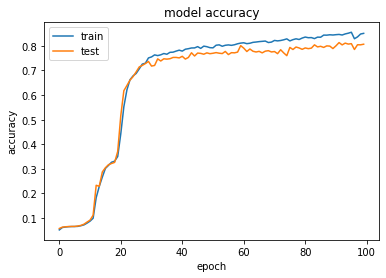

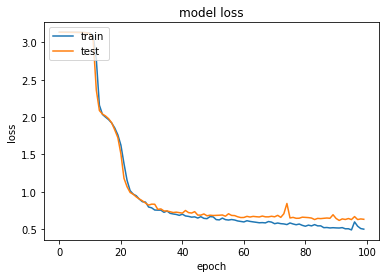

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate the Model


In [ ]:
def get_images_and_segments_test_arrays():
  '''
  Gets a subsample of the val set as your test set

  Returns:
    Test set containing ground truth images and label maps
  '''
  y_true_segments = []
  y_true_images = []
  test_count = 64

  ds = validation_dataset.unbatch()
  ds = ds.batch(101)

  for image, annotation in ds.take(1):
    y_true_images = image
    y_true_segments = annotation


  y_true_segments = y_true_segments[:test_count, : ,: , :]
  y_true_segments = np.argmax(y_true_segments, axis=3)  

  return y_true_images, y_true_segments

# load the ground truth images and segmentation masks
y_true_images, y_true_segments = get_images_and_segments_test_arrays()

### Make Predictions

The output of our segmentation model has the shape `(height, width, 23)` where `23` is the number of classes. Each pixel value in those 23 slices indicates the probability of that pixel belonging to that particular class. If you want to create the predicted label map, then you can get the `argmax()` of that axis. This is shown in the following cell.

In [ ]:
# get the model prediction
results = model.predict(validation_dataset, steps=validation_steps)
# print(results)
# for each pixel, get the slice number which has the highest probability
results = np.argmax(results, axis=3)

## Compute Metrics

The function below generates the IOU and dice score of the prediction and ground truth masks.

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

A small smoothening factor is introduced in the denominators to prevent possible division by zero.

In [ ]:
def compute_metrics(y_true, y_pred):
  '''
  Computes IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label map
    y_pred (tensor) - predicted label map
  '''
  
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001

  for i in range(len(class_names)):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [ ]:
print(y_true_segments.shape)
print(results.shape)

## Display Predictions

(64, 224, 224)
(64, 224, 224)


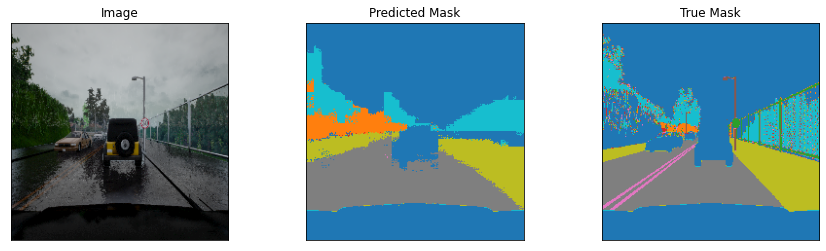

In [ ]:
# input a number from 0 to 63 to pick an image from the test set
integer_slider = 0

# compute metrics
iou, dice_score = compute_metrics(y_true_segments[integer_slider], results[integer_slider])  
print(y_true_segments.shape)
print(results.shape)
# visualize the output and metrics
show_predictions(y_true_images[integer_slider], [results[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou, dice_score)

In [ ]:
# compute metrics
cls_wise_iou, cls_wise_dice_score = compute_metrics(y_true_segments, results)

In [ ]:
# print IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou))


Unlabeled      0.8560664069258076 
Building       0.4612891480272302 
Fence          0.0015248553079318127 
Other          0.010570403069291901 
Pedestrian     1.320655043158142e-09 
Pole           0.00047265114060385374 
RoadLine       0.006776978307047319 
Road           0.7869585154351838 
SideWalk       0.554930992680911 
Vegetation     0.4065443880531571 
Vehicles       0.9170820807503895 
Wall           0.02337023456038461 
TrafficSign    5.030181061216394e-09 
Sky            1.0 
Ground         1.0 
Bridge         1.0 
RailTrack      1.0 
GuardRail      1.0 
TrafficLight   1.0 
Static         1.0 
Dynamic        1.0 
Water          1.0 
Terrain        1.0 


In [ ]:
# print the dice score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 

Unlabeled      0.9224523473252594 
Building       0.631345478281386 
Fence          0.003045067329299454 
Other          0.020919676727665346 
Pedestrian     2.641310086316284e-09 
Pole           0.0009448556944919878 
RoadLine       0.013462720055653426 
Road           0.8807798375215956 
SideWalk       0.7137692866144785 
Vegetation     0.5780754471912255 
Vehicles       0.9567478512971036 
Wall           0.045673078600898795 
TrafficSign    1.0060362122432788e-08 
Sky            2.0 
Ground         2.0 
Bridge         2.0 
RailTrack      2.0 
GuardRail      2.0 
TrafficLight   2.0 
Static         2.0 
Dynamic        2.0 
Water          2.0 
Terrain        2.0 
